# Negative L1 norm prior experiment

This code attempts to learn the 64D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(dim*t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 110597.984375
iteration 0 loss 90790.1640625


iteration 5000 loss 21.170225143432617


iteration 10000 loss 2.399414300918579


iteration 15000 loss 0.973807692527771


iteration 20000 loss 0.6175507307052612


iteration 25000 loss 0.4455346465110779


iteration 30000 loss 4.858280181884766


iteration 35000 loss 0.26153364777565


iteration 40000 loss 0.2265070229768753


iteration 45000 loss 0.20719125866889954


iteration 50000 loss 0.1551397144794464


iteration 55000 loss 0.13430455327033997


iteration 60000 loss 0.12018752098083496


iteration 65000 loss 0.2233438640832901


iteration 70000 loss 0.09969118982553482


iteration 75000 loss 0.08499521017074585


iteration 80000 loss 0.1020495817065239


iteration 85000 loss 0.1914333999156952


iteration 90000 loss 0.06691346317529678


iteration 95000 loss 0.06388130784034729


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.05716387927532196


iteration 105000 loss 0.05224970728158951


iteration 110000 loss 0.0400419607758522


iteration 115000 loss 0.035229574888944626


iteration 120000 loss 0.03127632290124893


iteration 125000 loss 0.02782333828508854


iteration 130000 loss 0.02598913200199604


iteration 135000 loss 0.022483933717012405


iteration 140000 loss 0.020354382693767548


iteration 145000 loss 0.01847645454108715


iteration 150000 loss 0.0169360488653183


iteration 155000 loss 0.01524908747524023


iteration 160000 loss 0.013905628584325314


iteration 165000 loss 0.012715985998511314


iteration 170000 loss 0.011656946502625942


iteration 175000 loss 0.010879198089241982


iteration 180000 loss 0.009824253618717194


iteration 185000 loss 0.00905840564519167


iteration 190000 loss 0.008341637440025806


iteration 195000 loss 0.007743151858448982


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.007136684842407703


iteration 205000 loss 0.006882989313453436


iteration 210000 loss 0.007014092057943344


iteration 215000 loss 0.005935885012149811


iteration 220000 loss 0.005528260953724384


iteration 225000 loss 0.0052250828593969345


iteration 230000 loss 0.004784832708537579


iteration 235000 loss 0.004470167215913534


iteration 240000 loss 0.004159570671617985


iteration 245000 loss 0.0038869776763021946


iteration 250000 loss 0.0036434317007660866


iteration 255000 loss 0.0034058585297316313


iteration 260000 loss 0.0031784665770828724


iteration 265000 loss 0.002985007129609585


iteration 270000 loss 0.0027961982414126396


iteration 275000 loss 0.0026145847514271736


iteration 280000 loss 0.0024549823720008135


iteration 285000 loss 0.002301778644323349


iteration 290000 loss 0.0021624912042170763


iteration 295000 loss 0.0020357321482151747


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0019121929071843624


iteration 305000 loss 0.0018423452274873853


iteration 310000 loss 0.0017323230858892202


iteration 315000 loss 0.001621437375433743


iteration 320000 loss 0.0015248407144099474


iteration 325000 loss 0.0014316815650090575


iteration 330000 loss 0.0013465762604027987


iteration 335000 loss 0.0012683471431955695


iteration 340000 loss 0.001188772963359952


iteration 345000 loss 0.0011224918998777866


iteration 350000 loss 0.0010578902438282967


iteration 355000 loss 0.0009967844234779477


iteration 360000 loss 0.0009370989282615483


iteration 365000 loss 0.0008846676792018116


iteration 370000 loss 0.000835287559311837


iteration 375000 loss 0.0007876001764088869


iteration 380000 loss 0.0007424051291309297


iteration 385000 loss 0.0006993408896960318


iteration 390000 loss 0.000660983903799206


iteration 395000 loss 0.0006251793238334358


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0005912642227485776


iteration 405000 loss 0.0005849174922332168


iteration 410000 loss 0.000547460513189435


iteration 415000 loss 0.0005076412344351411


iteration 420000 loss 0.00047076711780391634


iteration 425000 loss 0.000436643254943192


iteration 430000 loss 0.00040565707604400814


iteration 435000 loss 0.00037692245678044856


iteration 440000 loss 0.00035011162981390953


iteration 445000 loss 0.00032484717667102814


iteration 450000 loss 0.0003038545837625861


iteration 455000 loss 0.0002820522349793464


iteration 460000 loss 0.0002630055823829025


iteration 465000 loss 0.0002444852434564382


iteration 470000 loss 0.00022690743207931519


iteration 475000 loss 0.00021122598263900727


iteration 480000 loss 0.00019695243099704385


iteration 485000 loss 0.0001836375886341557


iteration 490000 loss 0.00017089582979679108


iteration 495000 loss 0.00015971979883033782


L2 loss -- Plot

loss -56.05241394042969


loss -206.77618408203125


loss -282.3304443359375


loss -334.65594482421875


loss -361.1330871582031


loss -368.8116455078125


loss -369.9590759277344


loss -370.04425048828125


loss -370.047119140625


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.047119140625


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.047119140625


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


loss -370.0471496582031


final mse:  2.3250277259023733e-09
max, min: 2.2258043 -2.1147814
loss -56.05241394042969


loss -205.4197998046875


loss -279.96038818359375


loss -330.9061279296875


loss -355.651123046875


loss -362.14947509765625


loss -362.986083984375


loss -363.0378723144531


loss -363.0392761230469


loss -363.039306640625


loss -363.039306640625


loss -363.0392761230469


loss -363.0392761230469


loss -363.0392761230469


loss -363.039306640625


loss -363.039306640625


loss -363.0392761230469


loss -363.039306640625


loss -363.039306640625


loss -363.039306640625


loss -363.039306640625


loss -363.039306640625


loss -363.039306640625


loss -363.039306640625


loss -363.0392761230469


loss -363.039306640625


loss -363.0392761230469


loss -363.039306640625


loss -363.0392761230469


loss -363.0392761230469


loss -363.0392761230469


loss -363.039306640625


loss -363.0392761230469


loss -363.0392761230469


loss -363.039306640625


loss -363.039306640625


loss -363.0392761230469


loss -363.039306640625


loss -363.039306640625


loss -363.0392761230469


final mse:  3.475717491596697e-09
max, min: 2.105642 -2.1387331


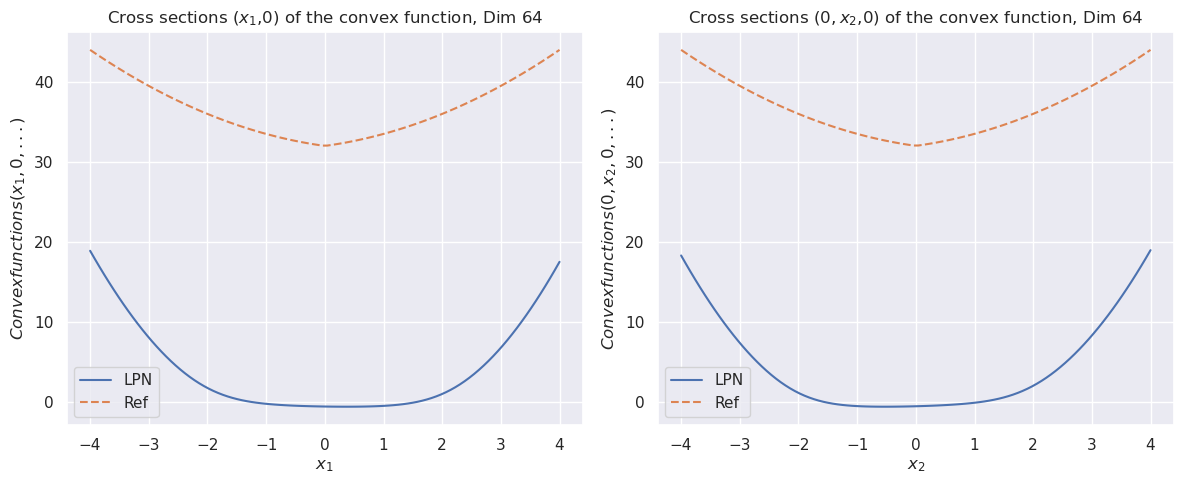

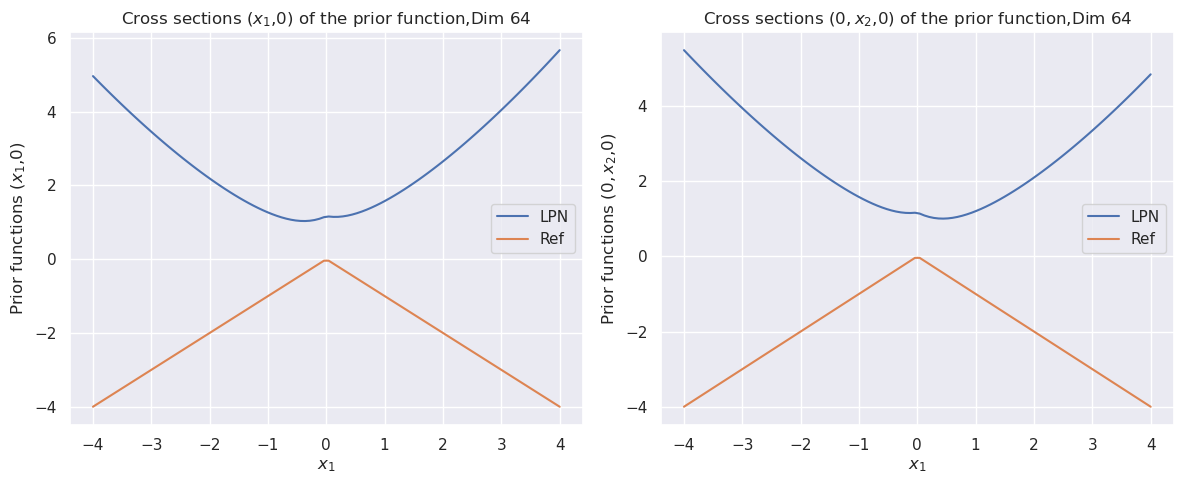

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 14072.130859375
iteration 0 loss 3796.711181640625


iteration 5000 loss 1.1634161472320557


iteration 10000 loss 0.6213616132736206


iteration 15000 loss 0.40576890110969543


iteration 20000 loss 0.28633788228034973


iteration 25000 loss 0.21420936286449432


iteration 30000 loss 0.2003585696220398


iteration 35000 loss 0.1465286910533905


iteration 40000 loss 0.09755820035934448


iteration 45000 loss 0.08274529874324799


iteration 50000 loss 0.17722880840301514


iteration 55000 loss 0.05229223519563675


iteration 60000 loss 0.05843017250299454


iteration 65000 loss 0.04455234855413437


iteration 70000 loss 0.035066332668066025


iteration 75000 loss 0.03132389485836029


iteration 80000 loss 0.027775079011917114


iteration 85000 loss 0.023184210062026978


iteration 90000 loss 0.030250459909439087


iteration 95000 loss 0.01913401670753956


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.016471004113554955


iteration 105000 loss 0.010603341273963451


iteration 110000 loss 0.007483546156436205


iteration 115000 loss 0.005654746200889349


iteration 120000 loss 0.0043714093044400215


iteration 125000 loss 0.0034738872200250626


iteration 130000 loss 0.002802421571686864


iteration 135000 loss 0.0022677858360111713


iteration 140000 loss 0.001857939874753356


iteration 145000 loss 0.0015185110969468951


iteration 150000 loss 0.0012768208980560303


iteration 155000 loss 0.0010597179643809795


iteration 160000 loss 0.000902917527128011


iteration 165000 loss 0.0007600244716741145


iteration 170000 loss 0.0006313691264949739


iteration 175000 loss 0.0005399679066613317


iteration 180000 loss 0.0004735217953566462


iteration 185000 loss 0.00039559678407385945


iteration 190000 loss 0.0003369918849784881


iteration 195000 loss 0.0002991817018482834


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0002608626673463732


iteration 205000 loss 0.00022507013636641204


iteration 210000 loss 0.00019339850405231118


iteration 215000 loss 0.00016679192776791751


iteration 220000 loss 0.000143280194606632


iteration 225000 loss 0.00012451903603505343


iteration 230000 loss 0.0001074655883712694


iteration 235000 loss 9.280422818847e-05


iteration 240000 loss 8.024994895095006e-05


iteration 245000 loss 6.948134978301823e-05


iteration 250000 loss 6.0143196606077254e-05


iteration 255000 loss 5.2384570153662935e-05


iteration 260000 loss 4.541794623946771e-05


iteration 265000 loss 0.00171729049179703


iteration 270000 loss 3.443793684709817e-05


iteration 275000 loss 3.0018389225006104e-05


iteration 280000 loss 2.616495476104319e-05


iteration 285000 loss 2.2925602024770342e-05


iteration 290000 loss 2.013858284044545e-05


iteration 295000 loss 1.7448724975110963e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 1.5246087968989741e-05


iteration 305000 loss 1.4007204299559817e-05


iteration 310000 loss 1.2475169569370337e-05


iteration 315000 loss 1.0936987564491574e-05


iteration 320000 loss 9.517081707599573e-06


iteration 325000 loss 8.33623835205799e-06


iteration 330000 loss 7.4179438342980575e-06


iteration 335000 loss 6.602951089007547e-06


iteration 340000 loss 5.802990017400589e-06


iteration 345000 loss 5.134417278895853e-06


iteration 350000 loss 4.599958629114553e-06


iteration 355000 loss 4.08213963964954e-06


iteration 360000 loss 3.5999378269480076e-06


iteration 365000 loss 3.241812464693794e-06


iteration 370000 loss 2.8970766834390815e-06


iteration 375000 loss 2.5733377242431743e-06


iteration 380000 loss 2.323659145986312e-06


iteration 385000 loss 2.0957127162546385e-06


iteration 390000 loss 1.8732457647274714e-06


iteration 395000 loss 1.6929268440435408e-06


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 1.5285559129551984e-06


iteration 405000 loss 1.464619913349452e-06


iteration 410000 loss 1.3242087106846157e-06


iteration 415000 loss 1.202015937451506e-06


iteration 420000 loss 1.0963429986077244e-06


iteration 425000 loss 1.0002834187616827e-06


iteration 430000 loss 9.090426260627282e-07


iteration 435000 loss 8.302055789499718e-07


iteration 440000 loss 7.609196472913027e-07


iteration 445000 loss 6.971000630073831e-07


iteration 450000 loss 6.401244263543049e-07


iteration 455000 loss 5.96569293520588e-07


iteration 460000 loss 5.540206871046394e-07


iteration 465000 loss 5.092117021376907e-07


iteration 470000 loss 4.804475111086504e-07


iteration 475000 loss 4.4611672933569935e-07


iteration 480000 loss 4.182472821412375e-07


iteration 485000 loss 3.927643206225184e-07


iteration 490000 loss 3.6413706538951374e-07


iteration 495000 loss 3.445424852088763e-07


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


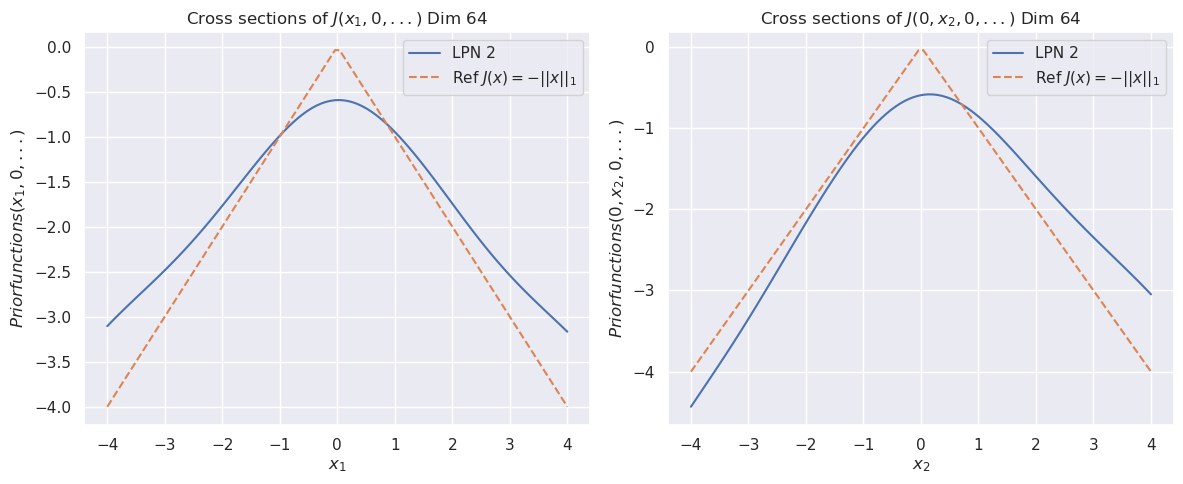

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)